# Final Project: Celebrity Face Detector

In [21]:
# Import necessary libraries
import os, hashlib, requests, json, cv2, numpy as np, pickle, random, matplotlib.pyplot as plt, math
from collections import defaultdict, Counter
from tqdm import tqdm
from sklearn import svm, metrics

## Download Images
For this project, the FaceScrub dataset will be used. The dataset comes as two .txt files, one for actors, and one for actresses. Each file is a tab-separated list of datapoints (name, image_id, face_id, url, bbox, sha256). The first step of the project is to determine which celebrities will be included. 10 actors and 10 actresses will be selected by the number of images of them in the dataset (20 classes total). The 10 actors and 10 actresses with the most datapoints will be used to keep the scale reasonable while having as many datapoints for each class as possible. Adjust run-time by increasing or decreasing the arguments of get_top_k_names in lines 84, 85, and the max number of images per class downloaded in download_and_save_images in lines 88, 89.

In [22]:
# Function to take in a faceScrub txt file and output each entry
def read_facescrub_metadata(filepath):
    entries = []
    with open(filepath, 'r') as f:
        # Skip first line
        lines = f.readlines()[1:]
        # For each line after the first
        for line in lines:
            # Split lines by tabs
            parts = line.strip().split('\t')
            # Discard bad data
            if len(parts) < 6:
                continue
            # Denote parts of line
            name, image_id, face_id, url, bbox, sha256 = parts
            # Entries only needs name, url, hash
            entries.append((name, url, sha256))
    return entries

# Function to find which name in a dataset is most common
def get_top_k_names(entries, k=10):
    counts = Counter([e[0] for e in entries])
    names = [name for name, _ in counts.most_common(k)]
    return names

# Function to confirm hash matches between expected and downloaded image
def sha256_matches(content, expected_hash):
    hasher = hashlib.sha256()
    hasher.update(content)
    return hasher.hexdigest() == expected_hash

# Function to download and save images to an output directory
def download_and_save_images(entries, selected_names, output_dir, label_offset, pictures_per_name):
    # Make the directory to save images to
    os.makedirs(output_dir, exist_ok=True)
    label_map = {}
    label_counter = label_offset

    grouped = defaultdict(list)
    # For the data in each entry,
    for name, url, sha256 in entries:
        if name in selected_names:
            # Add data to grouped dictionary
            grouped[name].append((url, sha256))

    # For each class (name),
    for name in tqdm(selected_names, desc = f"Downloading to {output_dir}"):
        # name_safe is the name with underscores instead of spaces
        name_safe = name.replace(' ', '_')
        # person_dir is a directory for the class
        person_dir = os.path.join(output_dir, name_safe)
        os.makedirs(person_dir, exist_ok=True)

        # If name hasn't been seen yet,
        if name not in label_map:
            # Add name to label_map
            label_map[name_safe] = label_counter
            label_counter += 1
        
        count = 0
        # For each url and hash
        for i, (url, sha256) in enumerate(grouped[name]):
            if len([entry for entry in os.listdir(person_dir) if os.path.isfile(os.path.join(person_dir, entry))]) < pictures_per_name and not os.path.exists(f"{i}.jpg"):
                # Try to download
                try:
                    # Get image
                    response = requests.get(url, timeout=0.1)
                    # If success,
                    if response.status_code == 200 and sha256_matches(response.content, sha256):
                        with open(os.path.join(person_dir, f"{i}.jpg"), 'wb') as f:
                            # Write image to i.jpg
                            f.write(response.content)
                # If an error, skip image
                except Exception as e:
                    continue
    # Return map of names to labels
    return label_map

# Load metadata
actor_entries = read_facescrub_metadata("faceScrub/facescrub_actors.txt")
actress_entries = read_facescrub_metadata("faceScrub/facescrub_actresses.txt")

# Get top names
top_actors = get_top_k_names(actor_entries, k=10)
top_actresses = get_top_k_names(actress_entries, k=10)

# Download images
actor_label_map = download_and_save_images(actor_entries, top_actors, "data/actors", 0, pictures_per_name=10)
actress_label_map = download_and_save_images(actress_entries, top_actresses, "data/actresses", len(actor_label_map), pictures_per_name=10)

# Save label map
full_label_map = {**actor_label_map, **actress_label_map}
with open("data/label_map.json", "w") as f:
    json.dump(full_label_map, f, indent=2)

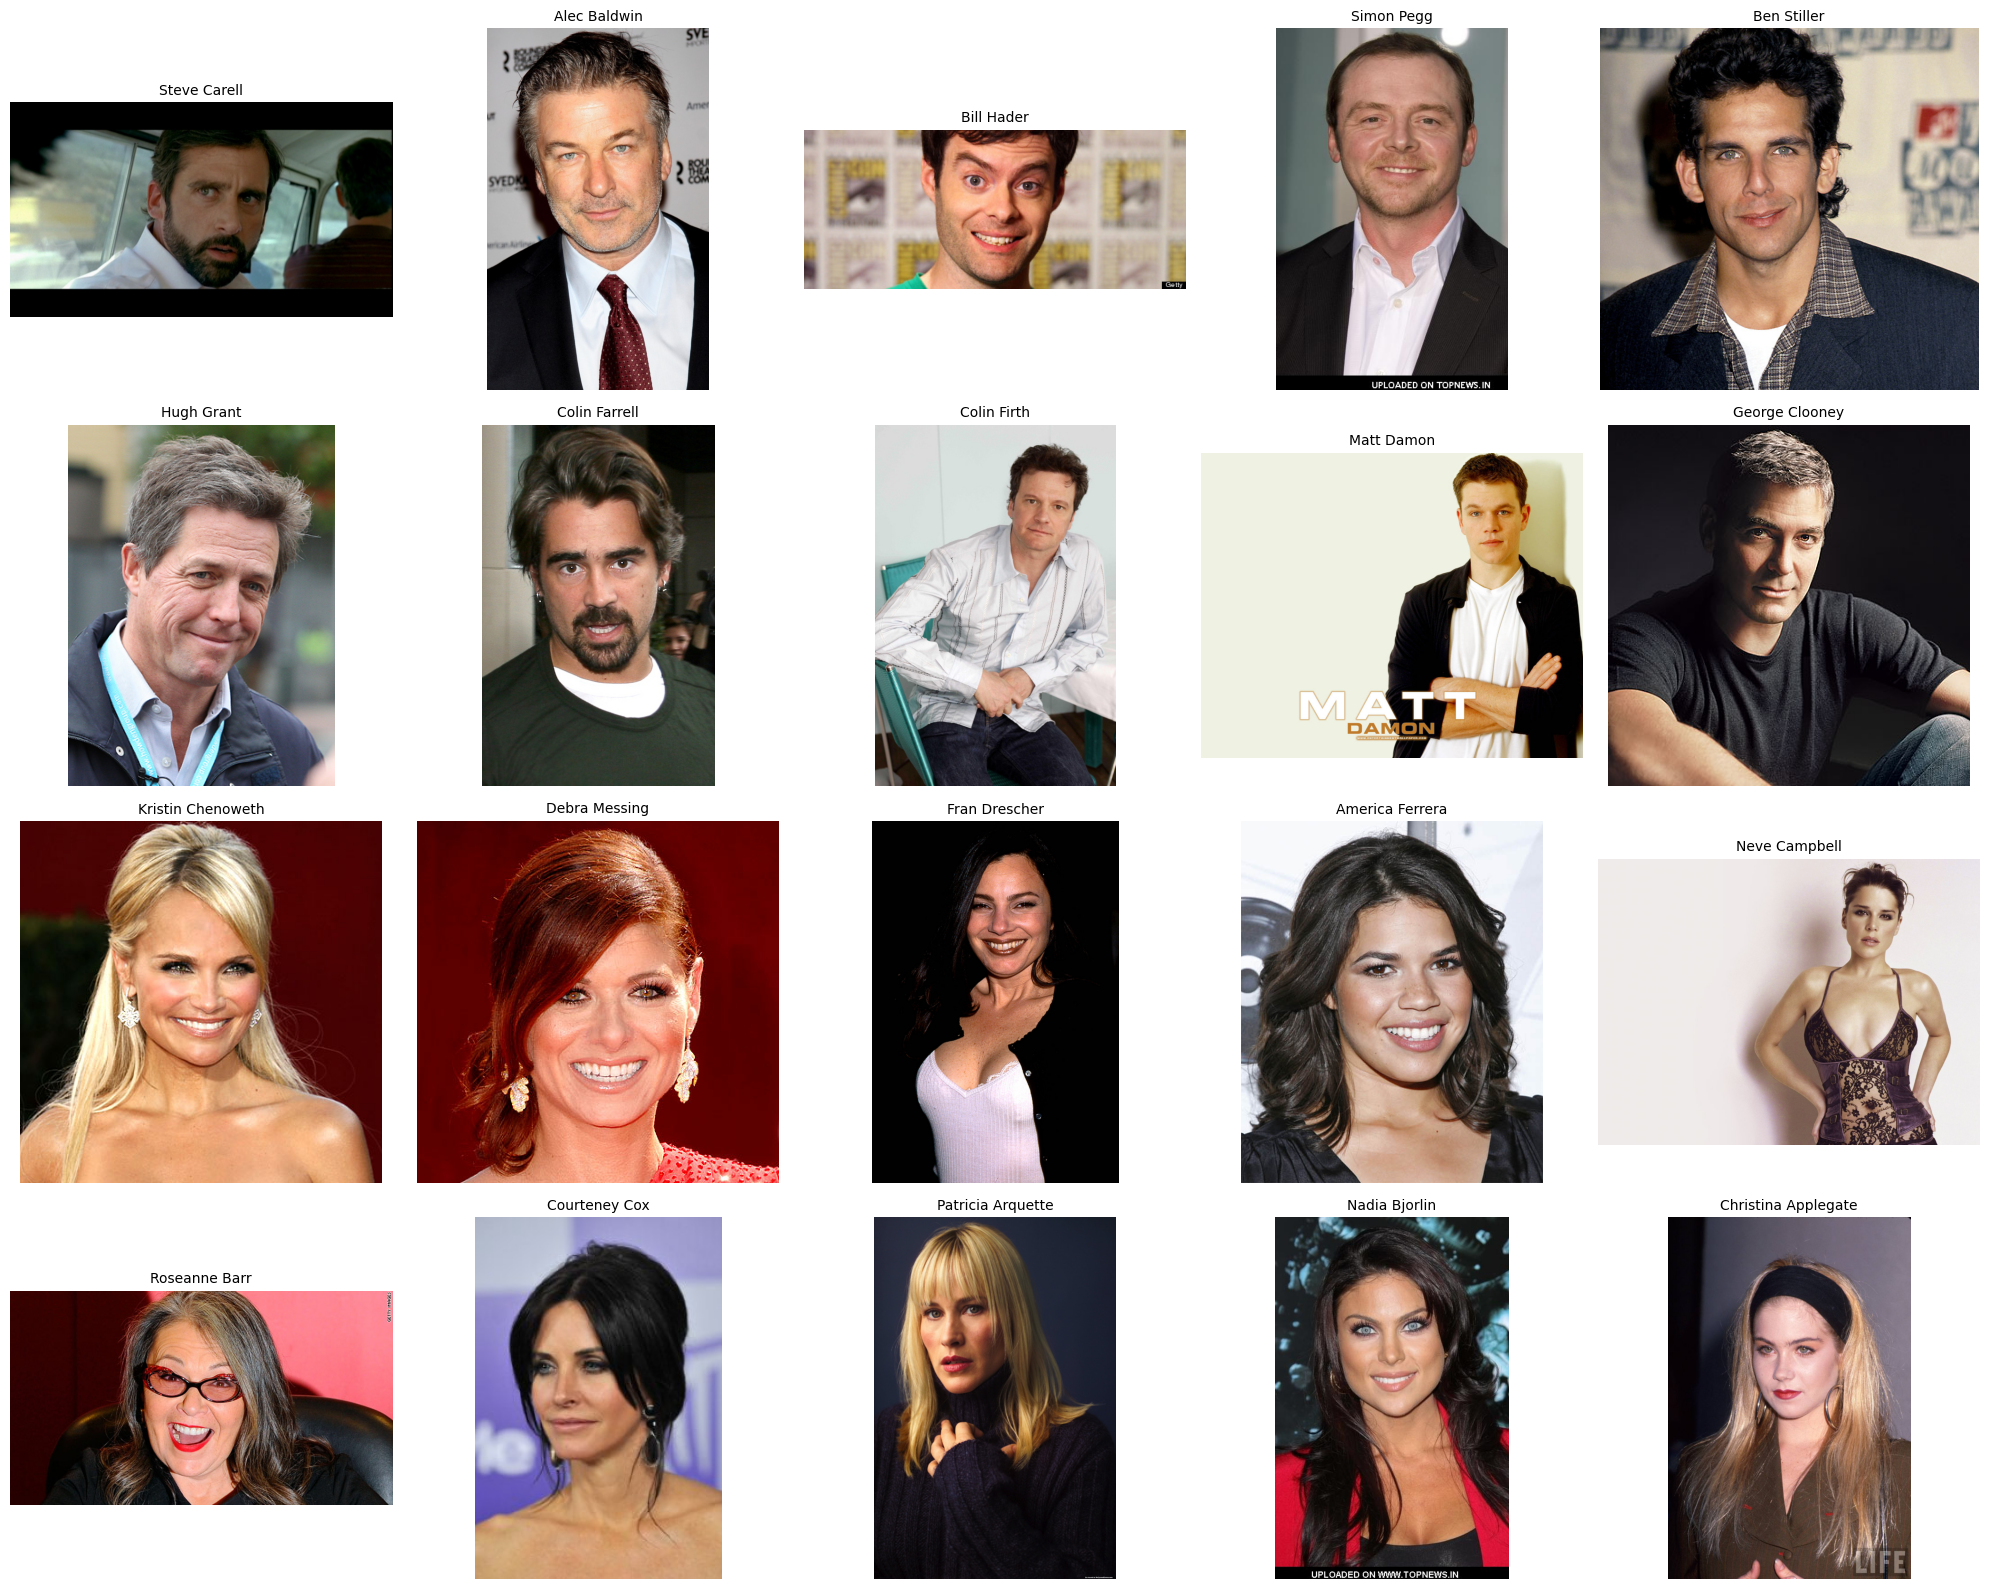

In [23]:
# Function to visualize random photos of the selected people
def vis1():
    # Get top names
    top_actors = get_top_k_names(actor_entries, 10)
    top_actresses = get_top_k_names(actress_entries, 10)
    
    # Combine names
    all_names = [("actors", name) for name in top_actors] + [("actresses", name) for name in top_actresses]

    # Get number of names and 
    n_rows = (len(all_names) + 5 - 1) // 5

    # Define plt plot
    fig, axs = plt.subplots(n_rows, 5, figsize=(5 * 4, n_rows * 4))
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]

    # For each person
    for idx, (category, name) in enumerate(all_names):
        ax = axs[idx]

        name = name.replace(' ', '_')
        
        # Get folder and image paths
        folder_path = os.path.join('data', category, name)
        image_files = os.listdir(folder_path)

        # Get random image of the person
        index = 0
        img = None
        while img is None:
            image_path = os.path.join(folder_path, image_files[index])
            # Read image and validate
            img = cv2.imread(image_path)
            index += 1

        
        # Convert color for plt
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Plot image
        ax.imshow(img)
        ax.axis('off')
        # Set title as name with space
        ax.set_title(name.replace('_', ' '), fontsize=10)
        
    plt.tight_layout()
    plt.show()
vis1()

## HOG Feature Extraction and Database Preparation
In order to classify faces, features must be extracted from the images. To increase accuracy, we'll first use the OpenCV Harr Cascade frontal face detector. Next, we crop to only the face, resize to a standard size (256x256), and rotate -10, 0, and 10 degrees. Finally, for each rotation, we'll extract HOG features and add the labeled feature vector to either the train or the test dataset.

In [24]:
# Function to rotate an image by given angles, and return a list of images
def rotate_image(image, angles):
    # Get height, width of image
    height, width = image.shape[:2]
    center = (width // 2, height // 2)

    image_list = []

    # For each angle defined
    for angle in angles:
        # Find rotation matrix for the angle
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        # Compute rotated image
        rotated = cv2.warpAffine(image, M, (width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
        # Add rotated image to list of images
        image_list.append(rotated)

    return image_list

# Define face cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Function to detect face and output crop of face from an image
def detect_and_crop_face(image_path, output_size):
    # Read and validate image
    img = cv2.imread(image_path)
    if img is None:
        # print(f"Failed to load image {image_path}")
        return None, False
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Brightness normalization
    gray = cv2.equalizeHist(gray)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

    # Check if a face is detected
    if len(faces) == 0:
        return None, False

    # Pick the largest face
    x, y, w, h = sorted(faces, key=lambda box: box[2] * box[3], reverse=True)[0]

    # Crop and resize
    face_img = img[y:y+h, x:x+w]
    face_img = cv2.resize(face_img, output_size)
    return face_img, True

# Function to compute HOG features
def extract_hog_features(image, cell_size = (8, 8), block_size = (2, 2), orientation_count = 9, epsilon = 1e-6):
    # Convertn image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Brightness normalization
    gray = cv2.equalizeHist(gray)
    
    # Compute sobel gradients
    gradient_x = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize = 1)
    gradient_y = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize = 1)

    # Compute magnitude and angle of gradient
    magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)
    angle = np.arctan2(gradient_y, gradient_x) * (180 / np.pi)

    # Initialize image height and width, cell height and width, count of cells in x and y directions, histogram, and bin size
    h, w = gray.shape
    cell_height = cell_size[0]
    cell_width = cell_size[1]
    cell_count_y = h // cell_height
    cell_count_x = w // cell_width
    histogram = np.zeros((cell_count_y, cell_count_x, orientation_count))
    bin_size = 180 / orientation_count

    # For each cell,
    for y in range(cell_count_y):
        for x in range(cell_count_x):
            # Get the magnitude and angle of the cell
            cell_magnitude = magnitude[y * cell_height: (y + 1) * cell_height, x * cell_width: (x+1) * cell_width]
            cell_angle = angle[y * cell_height: (y + 1) * cell_height, x * cell_width: (x+1) * cell_width]
            
            # Initialize array of zeros for histogram of one cell
            hist = np.zeros(orientation_count)
            # For each pixel in the cell,
            for i in range(cell_height):
                for j in range(cell_width):
                    # Determine the bin the pixel belongs to
                    bin_idx = int(cell_angle[i, j] // bin_size) % orientation_count
                    # Add the pixel's magnitude to the histogram at the bin's index
                    hist[bin_idx] += cell_magnitude[i, j]
            # Add the pixel histogram to the cell's histogram
            histogram[y, x, :] = hist
    
    # Define block height and width, number of blocks in x and y direction
    block_height, block_width = block_size
    n_blocks_y = cell_count_y - block_height + 1
    n_blocks_x = cell_count_x - block_width + 1

    # Initialize return vector
    hog_vector = []

    # For each block,
    for y in range(n_blocks_y):
        for x in range(n_blocks_x):
            # Define block as the histogram of just the block flattened to a vector
            block = histogram[y: y + block_height, x: x + block_width, :].flatten()
            # Compute L2 normalization divisor
            norm = np.linalg.norm(block) + epsilon
            # Append the normalized block vector to the hog_vector list
            hog_vector.extend(block / norm)

    # Return HOG vector as a NumPy array of floats
    return np.array(hog_vector, dtype=np.float32)

# Function to build dataset out of the images and save it as a file
def build_datasets(data_dir, label_map_path, output_path, output_size, test_split = 0.3):
    # Load label map
    with open(label_map_path, "r") as f:
        label_map = json.load(f)

    train_features = []
    train_labels = []
    train_image_arrays = []

    test_features = []
    test_labels = []
    test_image_arrays = []

    print("Building dataset...")

    # For each of actors, actresses, 
    for category in ["actors", "actresses"]:
        category_path = os.path.join(data_dir, category)
        if not os.path.exists(category_path):
            continue

        # For each name (folder)
        for person in os.listdir(category_path):
            person_dir = os.path.join(category_path, person)
            if not os.path.isdir(person_dir):
                continue
            
            # Get label from label map and validate
            label = label_map.get(person)
            if label is None:
                continue  

            images = os.listdir(person_dir)
            random.shuffle(images)

            split_idx = int(len(images) * (1 - test_split))
            train_images = images[:split_idx]
            test_images = images[split_idx:]

            # For each image of the person
            for image_name in train_images:
                image_path = os.path.join(person_dir, image_name)
                # Detect face and crop image
                face_img, success = detect_and_crop_face(image_path, output_size)
                # Skip if no face is detected or image import issues
                if not success or face_img is None:
                    continue 

                # Build rotations
                face_imgs = rotate_image(face_img, angles=[-10, 0, 10])

                for i, rotation in enumerate(face_imgs):
                    # Add image to image list
                    train_image_arrays.append(rotation)
                    # Get HOG features from the image
                    hog_feature = extract_hog_features(rotation)
                    # Add features to feature list
                    train_features.append(hog_feature)
                    # Add label to label list
                    train_labels.append(label)
            
            for image_name in test_images:
                image_path = os.path.join(person_dir, image_name)
                # Detect face and crop image
                face_img, success = detect_and_crop_face(image_path, output_size)
                # Skip if no face is detected or image import issues
                if not success or face_img is None:
                    continue

                # No rotation in test images.

                # Add image to image list
                test_image_arrays.append(face_img)
                # Get HOG features from the image
                hog_feature = extract_hog_features(face_img)
                # Add features to feature list
                test_features.append(hog_feature)
                # Add label to label list
                test_labels.append(label)
                    
    train_features = np.array(train_features)
    train_labels = np.array(train_labels)
    train_images = np.array(train_image_arrays)

    test_features = np.array(test_features)
    test_labels = np.array(test_labels)
    test_images = np.array(test_image_arrays)

    # Save dataset
    np.savez(os.path.join(output_path, 'train_dataset.npz'), features = train_features, labels = train_labels, images=train_images)
    np.savez(os.path.join(output_path, 'test_dataset.npz'), features = test_features, labels = test_labels, images = test_images)

    print(f"Saved datasets to {output_path}/ with {train_features.shape[0] + test_features.shape[0]} samples of feature size {train_features.shape[1]}.")

# Build dataset
build_datasets('data', 'data/label_map.json', 'data', output_size=(256, 256))

Building dataset...


libpng warning: iCCP: known incorrect sRGB profile


Saved datasets to data/ with 477 samples of feature size 34596.


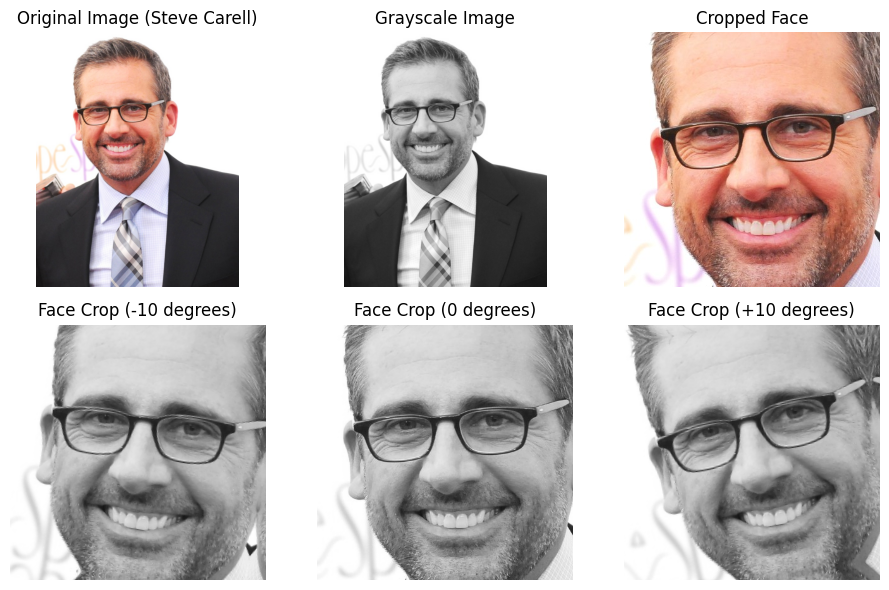

In [25]:
# Function to display transformations of original photo to dataset
def vis2():
    plt.figure(figsize=(15, 6))

    plt.subplot(2, 3, 1)
    original = cv2.imread('data/actors/Steve_Carell/5.jpg')
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image (Steve Carell)")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    grey = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    plt.imshow(cv2.cvtColor(grey, cv2.COLOR_BGR2RGB))
    plt.title("Grayscale Image")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    faceCrop, _ = detect_and_crop_face('data/actors/Steve_Carell/5.jpg', (256, 256))
    plt.imshow(cv2.cvtColor(faceCrop, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Face")
    plt.axis("off")

    minusFive, zero, plusFive = rotate_image(faceCrop, [-10, 0, 10])

    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(cv2.cvtColor(minusFive, cv2.COLOR_BGR2GRAY), cv2.COLOR_BGR2RGB))
    plt.title("Face Crop (-10 degrees)")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(cv2.cvtColor(cv2.cvtColor(zero, cv2.COLOR_BGR2GRAY), cv2.COLOR_BGR2RGB))
    plt.title("Face Crop (0 degrees)")
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.imshow(cv2.cvtColor(cv2.cvtColor(plusFive, cv2.COLOR_BGR2GRAY), cv2.COLOR_BGR2RGB))
    plt.title("Face Crop (+10 degrees)")
    plt.axis("off")

    plt.tight_layout(w_pad=-30)
vis2()

## Build and Train Classifier
In order to classify images, we'll use a one-vs-rest linear classification system. This means that for each class (name), we'll train an individual linear classifier to determine whether an image is of that person. Then, at runtime, we'll run test images through each classifier and determine the class of the image based on the linear classifier with the highest confidence. For convenience, the classifiers are saved as a file so that a future run can load in that set of classifiers.

In [26]:
# Function to train linear classifiers for each label
def train_classifiers(features, labels):
    # Dictionary of classifiers {label: classifier}
    classifiers = {}
    # Get unique labels
    unique_labels = np.unique(labels)
    # For each class to classify on,
    for label in tqdm(unique_labels, desc="Training classifiers"):
        # Make list of labels as 0 or 1
        binary_labels = (labels == label).astype(int)
        # Define linear classifier
        clf = svm.LinearSVC(max_iter = 10000, tol=1e-2)
        # Train linear classifier on features and labels
        clf.fit(features, binary_labels)
        # Add classifier to dictionary under key label
        classifiers[label] = clf
    # Return classifier dictionary
    return classifiers

# Function to classify a list of feature vectors
def one_vs_rest_predict(classifiers, features):
    # List of scores where index is label
    label_scores = []

    # For each label and its classifier,
    for label, clf in classifiers.items():
        # List of classification confidence for each image's features
        scores = clf.decision_function(features)
        # Add scores to label_scores
        label_scores.append(scores)

    # Convert label_scores to NumPy array
    label_scores = np.array(label_scores)

    # Pick label with the highest score
    predicted_labels = np.argmax(label_scores, axis=0)
    # Return list of labels
    return np.array([list(classifiers.keys())[idx] for idx in predicted_labels])

# Function to get names back from numeric label
def labels_to_names(predicted_labels, label_map_path):
    # Load label map
    with open(label_map_path, "r") as f:
        label_map = json.load(f)
    # Invert values and keys in label map
    id_to_name = {label: name for name, label in label_map.items()}
    names = []
    # For each numeric label,
    for label in predicted_labels:
        # Get the name with the space removed
        name_underscore = id_to_name.get(label, "Unknown")
        # Fix the name
        name_space = name_underscore.replace('_', ' ')
        # Add to the list of names
        names.append(name_space)
    # Return the list of names
    return names

# FALSE: Make new classifiers out of dataset.npz files
# TRUE: Use saved classifiers in classifiers.clf
load = True
# Define classifier path
classifier_path = "data/classifiers.clf"

if not load:
    # Load train and test data
    train_data = np.load("data/train_dataset.npz")
    test_data = np.load("data/test_dataset.npz")

    X_train = train_data["features"]
    y_train = train_data["labels"]
    train_images = train_data["images"]

    X_test = test_data["features"]
    y_test = test_data["labels"]
    test_images = test_data["images"]

    # Train classifiers
    classifiers = train_classifiers(X_train, y_train)

    with open(classifier_path, "wb") as f:
        pickle.dump((X_train, X_test, y_train, y_test, classifiers), f)
        print(f"Saved data to {classifier_path}")

# Import train and test data, classifiers, from file
else:
    if os.path.exists(classifier_path):
        with open(classifier_path, "rb") as f:
            X_train, X_test, y_train, y_test, classifiers = pickle.load(f)
        print(f"Data loaded from {classifier_path}")
    else: print("File not found")

# Make predictions on test data
print("Classifying test data...")
y_pred = one_vs_rest_predict(classifiers, X_test)

# Evaluate metrics on classification
print("Evaluation:")
names_test = labels_to_names(y_test, 'data/label_map.json')
names_pred = labels_to_names(y_pred, 'data/label_map.json')
print(metrics.classification_report(names_test, names_pred))
print(metrics.confusion_matrix(names_test, names_pred))

Data loaded from data/classifiers.clf
Classifying test data...
Evaluation:
                     precision    recall  f1-score   support

       Alec Baldwin       0.50      0.67      0.57         3
    America Ferrera       0.25      0.33      0.29         3
        Ben Stiller       0.25      0.33      0.29         3
         Bill Hader       0.75      1.00      0.86         3
Christina Applegate       0.60      1.00      0.75         3
      Colin Farrell       0.00      0.00      0.00         3
        Colin Firth       1.00      0.33      0.50         3
      Courteney Cox       0.25      0.33      0.29         3
      Debra Messing       0.67      0.67      0.67         3
      Fran Drescher       0.50      0.67      0.57         3
     George Clooney       1.00      0.33      0.50         3
         Hugh Grant       0.00      0.00      0.00         3
  Kristin Chenoweth       1.00      0.33      0.50         3
         Matt Damon       1.00      0.67      0.80         3
      Nad

/Users/samgreenfield/My Drive/College/2024-25/Spring/CSCI-B 457/spgreenf/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/samgreenfield/My Drive/College/2024-25/Spring/CSCI-B 457/spgreenf/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/samgreenfield/My Drive/College/2024-25/Spring/CSCI-B 457/spgreenf/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels w

Found 21 Training Images, 1 True Positives, 2 False Negatives, 3 False Positives for Steve Carell
Training Images:


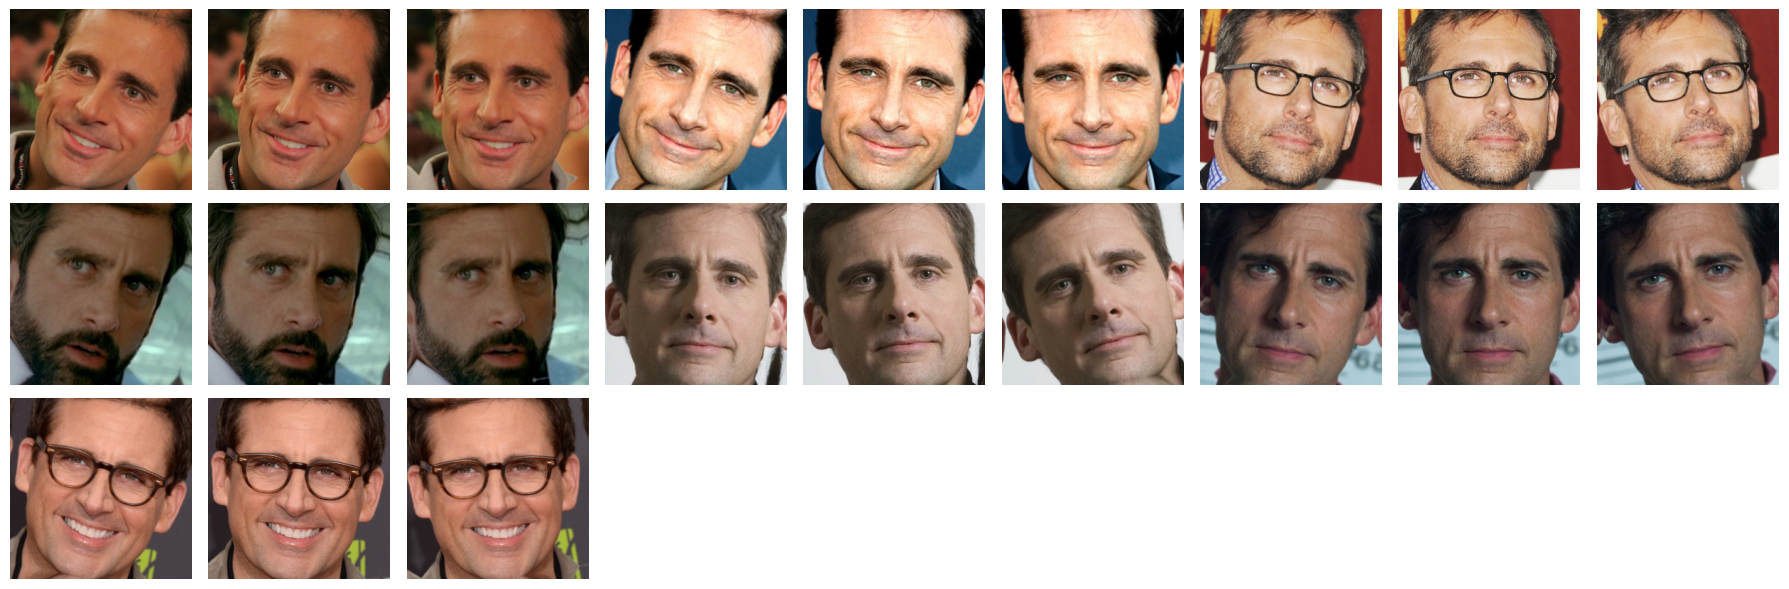

True Positives:


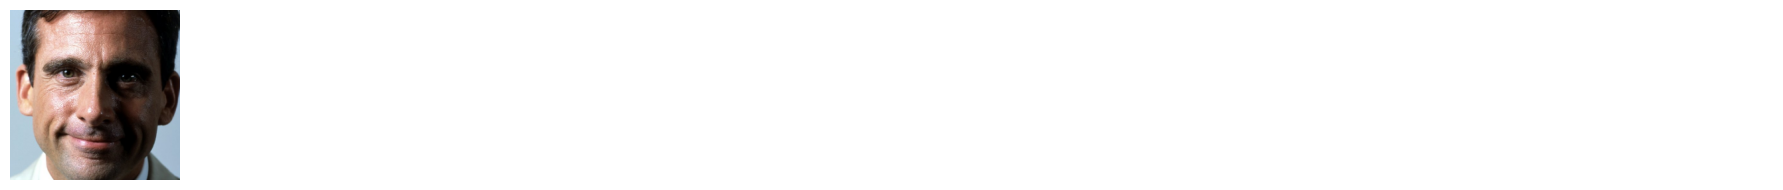

False Negatives:


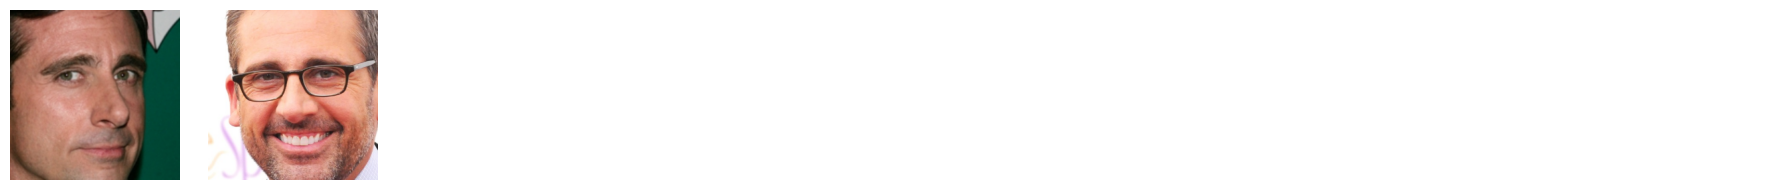

False Positives


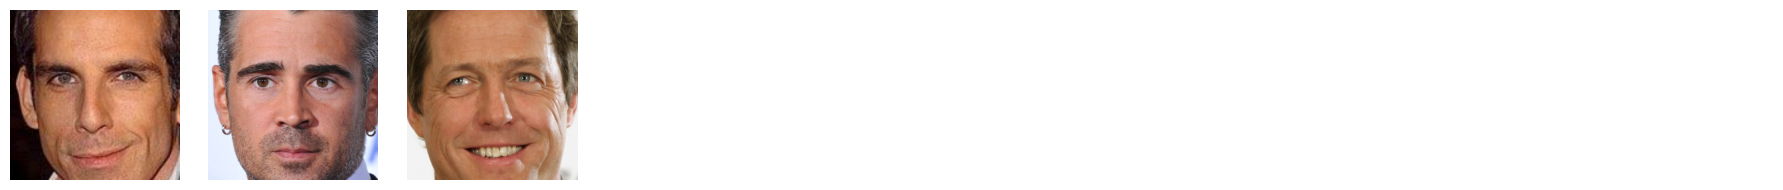

In [27]:
# Function to display training, true positive, false negative, and false positive images
def vis3():
    # Load label map
    with open('data/label_map.json', "r") as f:
        label_map = json.load(f)

    # Map name to label
    name_to_label = {name.replace('_', ' '): label for name, label in label_map.items()}

    # Define name of celebrity to visualize
    name = "Steve Carell"
    # Get name's label
    target_label = name_to_label.get(name)

    # Get all indices of relevant label
    train_indices = np.where(y_train == target_label)[0]

    # Import images from dataset
    images_train = np.load('data/train_dataset.npz')["images"]
    images_test = np.load('data/test_dataset.npz')["images"]

    # Get size of training data and compute rows
    train_size = len(train_indices)
    train_rows = math.ceil(train_size / 9)

    # List for each detection
    true_positives = []
    false_negatives = []
    false_positives = []

    # For each truth value,
    for idx in range(len(y_test)):
        # Get the image, its true value, and its predicted value
        img = images_test[idx]
        true = y_test[idx]
        prediction = y_pred[idx]
        
        # If positive and predicted positive,
        if true == target_label and prediction == target_label:
            # True positive
            true_positives.append(img)
        # If positive and predicted negative,
        elif true == target_label and prediction != target_label:
            # False negative
            false_negatives.append(img)
        # If negative and predicted positive,
        elif true != target_label and prediction == target_label:
            # False positive
            false_positives.append(img)

    # Print counts of each type to be displayed
    print(f"Found {train_size} Training Images, {len(true_positives)} True Positives, {len(false_negatives)} False Negatives, {len(false_positives)} False Positives for {name}")

    # Function to plot a list of images (for detections)
    def plot_images(images):
        # Get number of imagesand rows
        n = len(images)
        n_rows = math.ceil(n / 9)

        # Create plt plot
        fig, axs = plt.subplots(n_rows, 9, figsize=(9 * 2, n_rows * 2))
        if isinstance(axs, np.ndarray):
            axs = axs.flatten()
        else:
            axs = [axs]

        # For each slot in a columns * rows
        for i in range(9 * n_rows):
            # If there's an image for the slot
            if i < n:
                # Display the image in the slot
                img = images[i].copy()
                axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                axs[i].axis('off')
            # Otherwise,
            else:
                # Display nothing
                axs[i].axis('off')

        plt.tight_layout()
        plt.show()

    print("Training Images:")
    # Plot training images (same logic as plot_images(), but with train_indices as index for get image)
    fig, axs = plt.subplots(train_rows, 9, figsize=(9 * 2, train_rows * 2))
    axs = axs.flatten() if train_size > 1 else [axs]
    for i in range(9 * train_rows):
        if i < train_size:
            idx = train_indices[i]
            img = images_train[idx].copy()
            axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axs[i].axis('off')
        else:
            axs[i].axis('off')
    plt.tight_layout()
    plt.show()

    # If there are true posivies,
    if true_positives:
        print("True Positives:")
        # Display them
        plot_images(true_positives)
    # If there are false negatives,
    if false_negatives:
        print("False Negatives:")
        # Display them
        plot_images(false_negatives)
    # If there are false positives,
    if false_positives:
        print("False Positives")
        # Display them
        plot_images(false_positives)
    plt.show()
vis3()